## Vehicle Detection Project

The goals / steps of this project are the following:

* Perform a Histogram of Oriented Gradients (HOG) feature extraction on a labeled training set of images and train a classifier Linear SVM classifier
* Optionally, you can also apply a color transform and append binned color features, as well as histograms of color, to your HOG feature vector. 
* Note: for those first two steps don't forget to normalize your features and randomize a selection for training and testing.
* Implement a sliding-window technique and use your trained classifier to search for vehicles in images.
* Run your pipeline on a video stream (start with the test_video.mp4 and later implement on full project_video.mp4) and create a heat map of recurring detections frame by frame to reject outliers and follow detected vehicles.
* Estimate a bounding box for vehicles detected.

In [3]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from mpl_toolkits.mplot3d import Axes3D
import glob
import time
import os

from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from skimage.feature import hog
from skimage import color, exposure

from scipy.ndimage.measurements import label
import sys
from importlib import reload

%matplotlib inline
plt.rc('figure', figsize=(12,12))

In [30]:
# %load_ext autoreload
# %autoreload 2

# from helper import *

In [31]:
# %reload_ext autoreload

In [10]:
# to display full output of all commands, not only last result
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

## Make a list of images to read in

In [5]:
# images are divided up into vehicles and non-vehicles

car_list = glob.glob('dataset/vehicles/**/*.png', recursive=True)
len(car_list)

notcar_list = glob.glob('dataset/non-vehicles/**/*.png', recursive=True)
len(notcar_list)

image_list = car_list + notcar_list
len(image_list)

8792

8968

17760

In [ ]:
def draw_boxes(img, bboxes, color=(0, 0, 255), thickness=6):
    """
    Define a function that takes an image, a list of bounding boxes,
    and optional color tuple and line thickness as inputs,
    then draws boxes in that color on the output
    """
    # make a copy of the image
    draw_img = np.copy(img)

    # draw each bounding box on your image copy using cv2.rectangle()
    for pt in bboxes:
        cv2.rectangle(draw_img, pt[0], pt[1], color, thickness)

    # return the image copy with boxes drawn
    return draw_img  # Change this line to return image copy with boxes

In [ ]:
# test

In [ ]:
def plot_color_hist(image, nbins=32, bins_range=(0, 256)):
    """
    Define a function to compute color histogram features
    """
    # Compute the histogram of the RGB channels separately
    rhist = np.histogram(image[:, :, 0], bins=32, range=(0, 256))
    ghist = np.histogram(image[:, :, 1], bins=32, range=(0, 256))
    bhist = np.histogram(image[:, :, 2], bins=32, range=(0, 256))

    # Generating bin centers
    bin_edges = rhist[1]
    bin_centers = (bin_edges[1:] + bin_edges[0:len(bin_edges) - 1]) / 2

    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((rhist[0], ghist[0], bhist[0]))

    # Return the individual histograms, bin_centers and feature vector
    return rhist, ghist, bhist, bin_centers, hist_features

In [ ]:
def plot3d(pixels, colors_rgb, axis_labels=list("RGB"), axis_limits=((0, 255), (0, 255), (0, 255))):
    """Plot pixels in 3D."""

    # Create figure and 3D axes
    fig = plt.figure(figsize=(8, 8))
    ax = Axes3D(fig)

    # Set axis limits
    ax.set_xlim(*axis_limits[0])
    ax.set_ylim(*axis_limits[1])
    ax.set_zlim(*axis_limits[2])

    # Set axis labels and sizes
    ax.tick_params(axis='both', which='major', labelsize=14, pad=8)
    ax.set_xlabel(axis_labels[0], fontsize=16, labelpad=16)
    ax.set_ylabel(axis_labels[1], fontsize=16, labelpad=16)
    ax.set_zlabel(axis_labels[2], fontsize=16, labelpad=16)

    # Plot pixel values with colors given in colors_rgb
    ax.scatter(
        pixels[:, :, 0].ravel(),
        pixels[:, :, 1].ravel(),
        pixels[:, :, 2].ravel(),
        c=colors_rgb.reshape((-1, 3)), edgecolors='none')

    return ax  # return Axes3D object for further manipulation


In [ ]:
def visualize(nrows, ncols, images, titles):
    for i, img in enumerate(images):
        plt.subplot(nrows, ncols, i + 1)
        plt.title(i + 1)
        img_dims = len(img.shape)
        if img_dims < 3:
            plt.imshow(img, cmap='hot')
            plt.title(titles[i])
        else:
            plt.imshow(img)
            plt.title(titles[i])


In [ ]:
def get_color_space(image, color_space='RGB'):
    """
    Define a function to compute color histogram features
    Pass the color_space flag as 3-letter all caps string
    like 'HSV' or 'LUV' etc.
    KEEP IN MIND IF YOU DECIDE TO USE THIS FUNCTION LATER IN YOUR PROJECT
    THAT IF YOU READ THE IMAGE WITH cv2.imread() INSTEAD YOU START WITH BGR COLOR!

    color_space can be RGB, HSV, LUV, HLS, YUV, YCrCb
    """
    if color_space == 'HSV':
        feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    elif color_space == 'LUV':
        feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
    elif color_space == 'HLS':
        feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
    elif color_space == 'YUV':
        feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
    elif color_space == 'YCrCb':
        feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
    else:
        feature_image = np.copy(image)

    return feature_image


In [ ]:
def bin_spatial(image, size=(32, 32)):
    """
    Define a function to compute binned color features
    """
    # Use cv2.resize().ravel() to create the feature vector
    ch1_features = cv2.resize(image[:, :, 0], size).ravel()
    ch3_features = cv2.resize(image[:, :, 1], size).ravel()
    ch2_features = cv2.resize(image[:, :, 2], size).ravel()

    # Return the feature vector
    return np.hstack((ch1_features, ch2_features, ch3_features))


In [ ]:
def color_hist(image, nbins=32):
    """
    Define a function to compute color histogram features
    """
    # Compute the histogram of the RGB channels separately
    ch1_hist = np.histogram(image[:, :, 0], bins=nbins)
    ch2_hist = np.histogram(image[:, :, 1], bins=nbins)
    ch3_hist = np.histogram(image[:, :, 2], bins=nbins)

    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((ch1_hist[0], ch2_hist[0], ch3_hist[0]))

    # Return the feature vector
    return hist_features


In [ ]:
def get_hog_features(image, orient, pix_per_cell, cell_per_block,
                     vis=False, feature_vec=True):
    """
    Define a function to return HOG features and visualization
    Features will always be the first element of the return
    Image data will be returned as the second element if visualize = True
    Otherwise, there is no second return element
    """
    assert len(image.shape) == 2, "image should be a gray to apply to hog()"

    hogs = hog(image,
               orientations=orient,
               pixels_per_cell=(pix_per_cell, pix_per_cell),
               cells_per_block=(cell_per_block, cell_per_block),
               block_norm='L2-Hys',
               transform_sqrt=True,
               visualise=vis,
               feature_vector=feature_vec)
    if vis:
        hog_features, hog_image = hogs[0], hogs[1]
        return hog_features, hog_image
    else:
        hog_features = hogs
        return hog_features

In [ ]:
def hog_features_for_image(feature_img, orient=9,
                           pix_per_cell=8, cell_per_block=2, hog_channel=0):

    # Call get_hog_features() with vis=False, feature_vec=True
    if hog_channel == 'ALL':
        hog_features = []
        # since hog() takes 2D array, we need to flatten the channels, if 'ALL' channels
        # needs to be used
        for channel in range(feature_img.shape[2]):
            hog_features.append(get_hog_features(feature_img[:, :, channel],
                                                 orient, pix_per_cell, cell_per_block,
                                                 vis=False, feature_vec=True))
        hog_features = np.ravel(hog_features)
    else:
        # otherwise, just use 0th channel
        hog_features = get_hog_features(feature_img[:, :, hog_channel],
                                        orient, pix_per_cell, cell_per_block,
                                        vis=False, feature_vec=True)

    return hog_features

In [ ]:
def single_img_features(image, color_space='HSV', spatial_size=(32, 32),
                        hist_bins=32, orient=9,
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    """
    Define a function to extract features from a single image window
    This function is very similar to extract_features()
    just for a single image rather than list of images
    """
    # 1) Define an empty list to receive features
    img_features = []

    # 2) Apply color conversion if other than 'RGB'
    feature_img = get_color_space(image, color_space)

    # WARNING! The following order of feature extraction needs to be same for
    # both training and test images
    # 3) Compute spatial features if flag is set
    if spatial_feat is True:
        spatial_features = bin_spatial(feature_img, size=spatial_size)
        # 4) Append features to list
        img_features.append(spatial_features)

    # 5) Compute histogram features if flag is set
    if hist_feat is True:
        hist_features = color_hist(feature_img, nbins=hist_bins)
        # 6) Append features to list
        img_features.append(hist_features)

    # 7) Compute HOG features if flag is set
    if hog_feat is True:
        hog_features = hog_features_for_image(feature_img, orient,
                                              pix_per_cell, cell_per_block, hog_channel)
        # 8) Append features to list
        img_features.append(hog_features)

    # 9) Return concatenated array of features
    return np.concatenate(img_features)

In [ ]:
def extract_all_features(images, color_space='HSV', spatial_size=(32, 32),
                         hist_bins=32, orient=9,
                         pix_per_cell=8, cell_per_block=2, hog_channel=0,
                         spatial_feat=True, hist_feat=True, hog_feat=True):
    """
    Define a function to extract features from a list of images
    Have this function call bin_spatial() and color_hist()
    """
    # Create a list to append feature vectors to
    features = []

    # Iterate through the list of images
    for file in images:
        img = mpimg.imread(file)
        res = single_img_features(img, color_space, spatial_size, hist_bins, orient,
                                  pix_per_cell, cell_per_block, hog_channel,
                                  spatial_feat, hist_feat, hog_feat)
        features.append(res)

    # Return list of feature vectors
    return features


In [ ]:
def get_training_data(car_list, notcar_list, color_space='HSV', spatial_size=(32, 32), hist_bins=32,
                      orient=9, pix_per_cell=8, cell_per_block=2,
                      hog_channel=0, spatial_feat=True, hist_feat=True, hog_feat=True):
    t = time.time()
    # sample_size = 1000
    # random_idxs = np.random.randint(0, len(car_list), sample_size)
    # sample_cars = np.array(car_list)[random_idxs]
    # sample_notcars = np.array(notcar_list)[random_idxs]

    car_features = extract_all_features(car_list, color_space, spatial_size, hist_bins,
                                        orient, pix_per_cell, cell_per_block,
                                        hog_channel, spatial_feat, hist_feat, hog_feat)
    notcar_features = extract_all_features(notcar_list, color_space, spatial_size, hist_bins,
                                           orient, pix_per_cell, cell_per_block,
                                           hog_channel, spatial_feat, hist_feat, hog_feat)

    print('Using {} orientations, {} pixels per cell, {} cells per block, {} histogram bins, and {} spatial sampling'.format(orient, pix_per_cell, cell_per_block, hist_bins, spatial_size))
    print(round(time.time() - t), 'seconds to extract all car and notcar features')

    # Create an array stack of feature vectors
    X = np.vstack((car_features, notcar_features)).astype(np.float64)

    # Define the labels vector
    y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

    assert len(X) == len(y), "X and y should have same lengths"

    return X, y

In [ ]:
def classify(X, y, orient=9, pix_per_cell=8, cell_per_block=2):

    # Split up data into randomized training and test sets
    rand_state = np.random.randint(0, 100)
    X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                        test_size=0.2, random_state=rand_state)

    # Fit a per-column scaler
    X_scaler = StandardScaler().fit(X_train)
    # Apply the scaler to X
    X_train = X_scaler.transform(X_train)
    X_test = X_scaler.transform(X_test)

    print('Feature vector length: {}'.format(len(X_train[0])))

    # Use a linear SVC
    svc = LinearSVC()

    # Check the training time for the SVC
    t = time.time()
    svc.fit(X_train, y_train)
    t2 = time.time()
    print(round(t2 - t, 2), 'seconds to train SVC ...')

    # Check the score of the SVC
    print('Test Accuracy of SVC (on validation data) = ', round(svc.score(X_test, y_test), 4))

    return svc, X_scaler

In [ ]:
def slide_window(image, start=[None, None], stop=[None, None],
                 xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    """
    Define a function that takes an image, start and stop positions in both x and y,
    window size (x and y dimensions) and overlap fraction (for both x and y)
    Your function should return a list of bounding boxes for the search windows,
    which will then be passed to draw draw_boxes() function.
    """
    # If x and/or y start/stop positions not defined, set to image size
    if start[0] is None:
        start[0] = 0
    if start[1] is None:
        start[1] = 0
    if stop[0] is None:
        stop[0] = image.shape[1]
    if stop[1] is None:
        stop[1] = image.shape[0]

    # Compute the number of pixels per step in x/y
    x_steps = np.int(xy_window[0] * (1 - xy_overlap[0]))
    y_steps = np.int(xy_window[1] * (1 - xy_overlap[1]))

    # Initialize a list to append window positions to
    window_list = []

    # Loop through finding x and y window positions
    #     Note: you could vectorize this step, but in practice
    #     you'll be considering windows one by one with your
    #     classifier, so looping makes sense
    # Calculate each window position
    # Append window position to list
    current_x, current_y = start[0], start[1]
    while (current_y + xy_window[1]) <= stop[1]:  # slide over y
        while (current_x + xy_window[0]) <= stop[0]:  # slide over x
            current_window = ((current_x, current_y), (current_x + xy_window[0], current_y + xy_window[1]))
            window_list.append(current_window)
            current_x += x_steps
        current_y += y_steps
        current_x = start[0]

    # Compute the span of the region to be searched
    x_span = stop[0] - start[0]
    y_span = stop[1] - start[1]

    # Compute the number of windows in x/y
    n_x_windows = 1 + np.int((x_span - xy_window[0]) / x_steps)
    n_y_windows = 1 + np.int((y_span - xy_window[1]) / y_steps)
    assert len(window_list) == n_x_windows * n_y_windows, "needs to be equal"

    # Return the list of windows
    return window_list


In [ ]:
def search_windows(image, windows, classifier, scaler, color_space='HSV',
                   spatial_size=(32, 32), hist_bins=32, orient=9,
                   pix_per_cell=8, cell_per_block=2, hog_channel=0,
                   spatial_feat=True, hist_feat=True, hog_feat=True):
    """
    Define a function you will pass an image
    and the list of windows to be searched (output of slide_windows())
    """
    # 1) Create an empty list to receive positive detection windows
    on_windows = []

    # 2) Iterate over all windows in the list
    for window in windows:

        # 3) Extract the test window from original image
        test_img = cv2.resize(image[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))

        # 4) Extract features for that window using single_img_features()
        features = single_img_features(image=test_img, color_space=color_space, spatial_size=spatial_size,
                                       hist_bins=hist_bins, orient=orient,
                                       pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, hog_channel=hog_channel,
                                       spatial_feat=spatial_feat, hist_feat=hist_feat, hog_feat=hog_feat)

        # 5) Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))

        # 6) Predict using your classifier
        prediction = classifier.predict(test_features)

        # 7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)

    # 8) Return windows for positive detections
    return on_windows


In [ ]:
def convert_color(image, conv='RGB2YCrCb'):
    if conv == 'RGB2YCrCb':
        return cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
    if conv == 'BGR2YCrCb':
        return cv2.cvtColor(image, cv2.COLOR_BGR2YCrCb)
    if conv == 'RGB2LUV':
        return cv2.cvtColor(image, cv2.COLOR_RGB2LUV)


In [ ]:
def find_cars(image, y_start, y_stop, scale, classifier, X_scaler, orient,
              pix_per_cell, cell_per_block, spatial_size, hist_bins):
    """
    Define a single function that can extract features using hog sub-sampling and make predictions
    """
    # t = time.time()

    draw_img = np.copy(image)
    image = image.astype(np.float32) / 255

    img_tosearch = image[y_start:y_stop, :, :]
    ctrans_tosearch = convert_color(img_tosearch, conv='RGB2YCrCb')
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch,
                                     (np.int(imshape[1] / scale), np.int(imshape[0] / scale)))

    ch1 = ctrans_tosearch[:, :, 0]
    ch2 = ctrans_tosearch[:, :, 1]
    ch3 = ctrans_tosearch[:, :, 2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1
    nfeat_per_block = orient * cell_per_block**2

    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step + 1
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step + 1

    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)

    img_boxes = []
    count = 0
    for xb in range(nxsteps):
        for yb in range(nysteps):
            count += 1
            ypos = yb * cells_per_step
            xpos = xb * cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos + nblocks_per_window, xpos:xpos + nblocks_per_window].ravel()
            hog_feat2 = hog2[ypos:ypos + nblocks_per_window, xpos:xpos + nblocks_per_window].ravel()
            hog_feat3 = hog3[ypos:ypos + nblocks_per_window, xpos:xpos + nblocks_per_window].ravel()
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos * pix_per_cell
            ytop = ypos * pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop + window, xleft:xleft + window], (64, 64))

            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)

            # Scale features in the same order of training and make a prediction
            test_features = X_scaler.transform(
                np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))
            # test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))
            test_prediction = classifier.predict(test_features)

            if test_prediction == 1:
                xbox_left = np.int(xleft * scale)
                ytop_draw = np.int(ytop * scale)
                win_draw = np.int(window * scale)
                cv2.rectangle(draw_img,
                              (xbox_left, ytop_draw + y_start), (xbox_left + win_draw, ytop_draw + win_draw + y_start),
                              (0, 0, 255), 6)
                img_boxes.append(((xbox_left, ytop_draw + y_start), (xbox_left + win_draw, ytop_draw + win_draw + y_start)))

    # print(round(time.time() - t), 'seconds to run, total windows = ', count)

    return draw_img, img_boxes

In [ ]:
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap  # Iterate through list of bboxes


In [ ]:
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap


In [ ]:
def draw_labeled_bboxes(image, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1] + 1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(image, bbox[0], bbox[1], (0, 0, 255), 6)

    # Return the image
    return image


In [ ]:
def test_classifier(image, classifier, X_scaler, color_space='HSV',
                    spatial_size=(32, 32), hist_bins=32, orient=9,
                    pix_per_cell=8, cell_per_block=2, hog_channel=0,
                    spatial_feat=True, hist_feat=True, hog_feat=True,
                    start=[None, None], stop=[None, None], xy_window=(96, 96), xy_overlap=(0.5, 0.5)):
    # Check the prediction time for a single sample
    t = time.time()

    img = mpimg.imread(image)
    draw_image = np.copy(img)

    # Uncomment the following line if you extracted training
    # data from .png images (scaled 0 to 1 by mpimg) and the
    # image you are searching is a .jpg (scaled 0 to 255)
    img = img.astype(np.float32) / 255
    assert np.min(img) == 0 and np.max(img) == 1, "should be image of scaling [0,1]"

    windows = slide_window(img, start=start, stop=stop, xy_window=xy_window, xy_overlap=xy_overlap)

    hot_windows = search_windows(image=img, windows=windows, classifier=classifier,
                                 scaler=X_scaler, color_space=color_space,
                                 spatial_size=spatial_size, hist_bins=hist_bins,
                                 orient=orient, pix_per_cell=pix_per_cell, cell_per_block=cell_per_block,
                                 hog_channel=hog_channel,
                                 spatial_feat=spatial_feat, hist_feat=hist_feat, hog_feat=hog_feat)

    window_img = draw_boxes(draw_image, hot_windows, color=(0, 0, 255), thickness=6)

    print(round(time.time() - t), 'seconds to process one image searching with ', len(windows), 'windows')

    # plt.imshow(window_img)
    return window_img


## Feature parameters

In [7]:
# define the parameters for various feature extraction methods

color_space = 'YCrCb'     # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9                # HOG orientations
pix_per_cell = 8          # HOG pixels per cell
cell_per_block = 2        # HOG cells per block
hog_channel = 'ALL'       # Can be 0, 1, 2, or "ALL"
spatial_size = (32, 32)   # Spatial binning dimensions
hist_bins = 32            # Number of histogram bins
spatial_feat = True       # Spatial features on or off
hist_feat = True          # Histogram features on or off
hog_feat = True           # HOG features on or off

## Visualize some car and notcar images

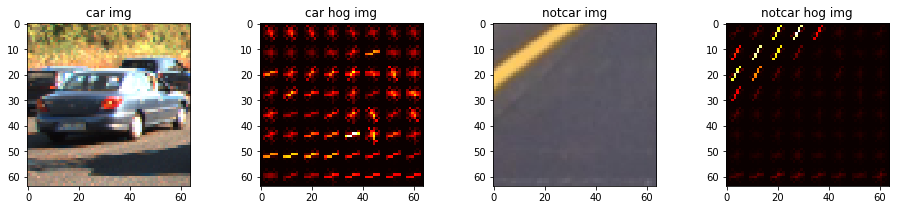

In [14]:
# randomly select some images from car and not car

i_car = np.random.randint(0, len(car_list))
i_notcar = np.random.randint(0, len(notcar_list))

img_car = mpimg.imread(car_list[i_car])
img_notcar = mpimg.imread(notcar_list[i_notcar])


img_car_g = cv2.cvtColor(img_car, cv2.COLOR_RGB2GRAY)
car_features, hog_img_car = get_hog_features(img_car_g, orient, pix_per_cell, cell_per_block, 
                                             vis=True, feature_vec=True)

img_notcar_g = cv2.cvtColor(img_notcar, cv2.COLOR_RGB2GRAY)
notcar_features, hog_img_notcar = get_hog_features(img_notcar_g, orient, pix_per_cell, cell_per_block,
                                                   vis=True, feature_vec=True)

# visualize
images = [img_car, hog_img_car, img_notcar, hog_img_notcar]
titles = ['car img', 'car hog img', 'notcar img', 'notcar hog img']
fig = plt.figure(figsize=(16,3))
visualize(1, 4, images, titles)

## Training

In [15]:
X, y = get_training_data(car_list=car_list, notcar_list=notcar_list, color_space=color_space,
                         spatial_size=spatial_size, hist_bins=hist_bins, orient=orient,
                         pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, hog_channel=hog_channel,
                         spatial_feat=spatial_feat, hist_feat=hist_feat, hog_feat=hog_feat)

Using 9 orientations, 8 pixels per cell, 2 cells per block, 32 histogram bins, and (32, 32) spatial sampling
184 seconds to extract all car and notcar features


In [ ]:
### Classify using a SVC
- use GridCV to find the best parameters

In [16]:
len(X)
len(y)
clf, scaler = classify(X, y, orient=orient, pix_per_cell=pix_per_cell, cell_per_block=cell_per_block)

17760

17760

Feature vector length: 8460
35.69 seconds to train SVC ...
Test Accuracy of SVC (on validation data) =  0.9887


### test the classifer

In [17]:
# new hyperparameters

start=[None, 400]
stop=[None, 656]
xy_window=(96, 96)       # for sliding window sizes
xy_overlap=(0.5, 0.5)    # for overlapping windows

In [18]:
clf
scaler
test_images = glob.glob('test_images/*.jpg', recursive=True)
len(test_images)

images = []
titles = []
for file in test_images:
    img = test_classifier(image = file, classifier=clf, X_scaler=scaler, color_space=color_space,
                    spatial_size=spatial_size, hist_bins=hist_bins, orient=orient,
                    pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, hog_channel=hog_channel,
                    spatial_feat=spatial_feat, hist_feat=hist_feat, hog_feat=hog_feat,
                    start=start, stop=stop, xy_window=xy_window, xy_overlap=xy_overlap)
    images.append(img)
    titles.append('')
    
print('done')

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)

StandardScaler(copy=True, with_mean=True, with_std=True)

6

1 seconds to process one image searching with  100 windows
1 seconds to process one image searching with  100 windows
1 seconds to process one image searching with  100 windows
1 seconds to process one image searching with  100 windows
1 seconds to process one image searching with  100 windows
1 seconds to process one image searching with  100 windows
done


<Figure size 1440x1440 with 0 Axes>

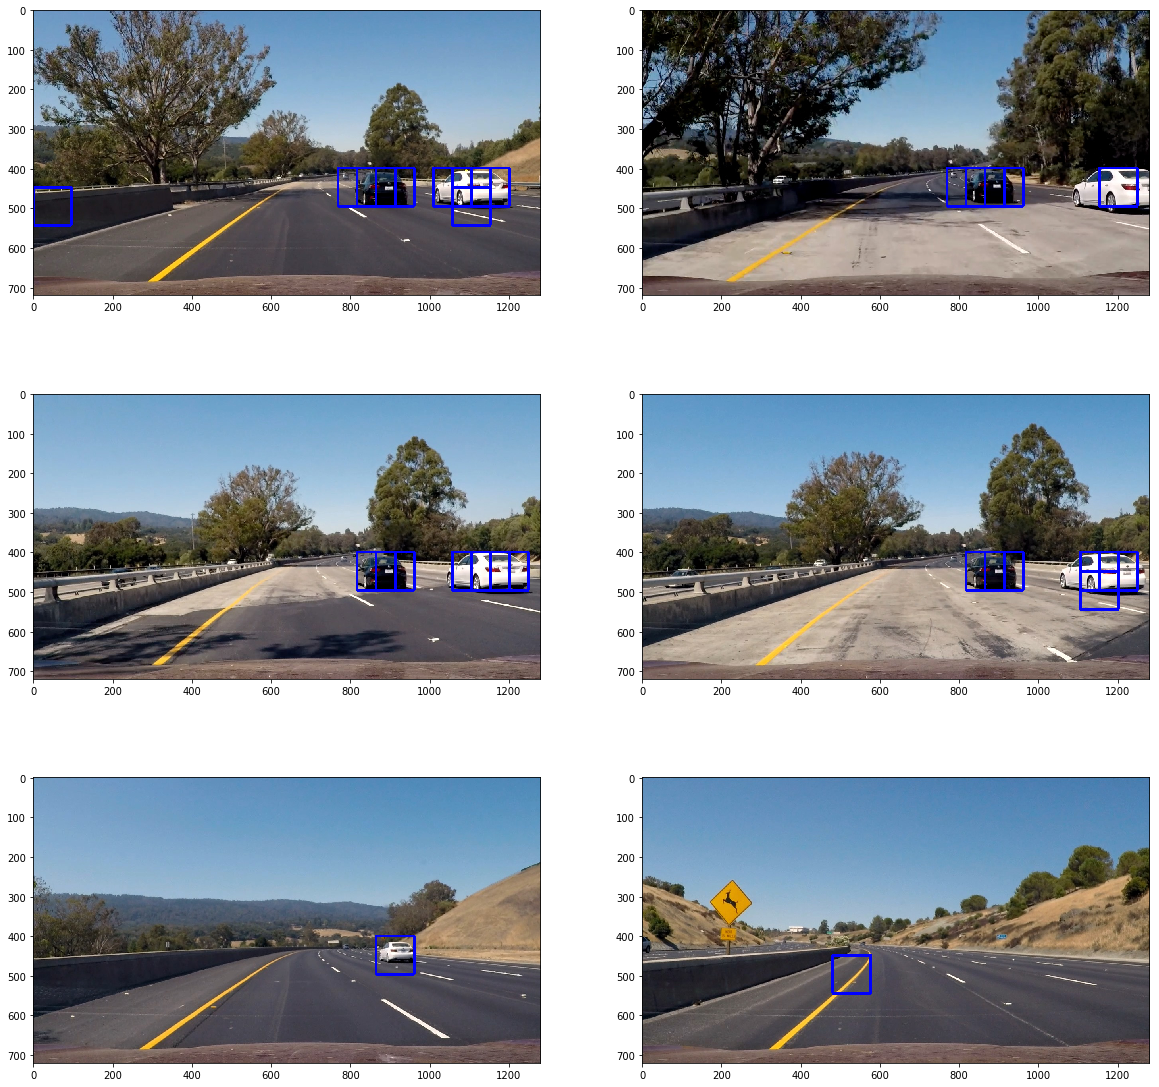

In [21]:
plt.figure(figsize=(20, 20))
visualize(3, 2, images, titles)

## Efficient hog + False positive removal

In [24]:
out_images = []
# out_maps = []
out_titles = []
# out_boxes = []

# consider only the bottom section of the images
y_start = 400
y_stop = 656
scale = 1.7
threshold = 1.9

for file in test_images:
    img = mpimg.imread(file)
    # make a heatmap of zeros
    heatmap = np.zeros_like(img[:,:,0])
    
    _, img_boxes = find_cars(image=img, y_start=y_start, y_stop=y_stop, scale=scale, classifier=clf,
                                    X_scaler=scaler, orient=orient, pix_per_cell=pix_per_cell,
                                    cell_per_block=cell_per_block, spatial_size=spatial_size, 
                                    hist_bins=hist_bins)    
    
    heatmap = add_heat(heatmap, img_boxes)    
    # remove false positives
    heatmap = apply_threshold(heatmap=heatmap, threshold=threshold)    
    # draw bounding boxes on a copy of the image
    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(np.copy(img), labels)
    
    out_images.append(draw_img)
    out_titles.append(file[-9:])
    out_images.append(heatmap)
    out_titles.append(file[-9:])
#     out_maps.append(heatmap)
#     out_boxes.append(img_boxes)
    
print('done')

done


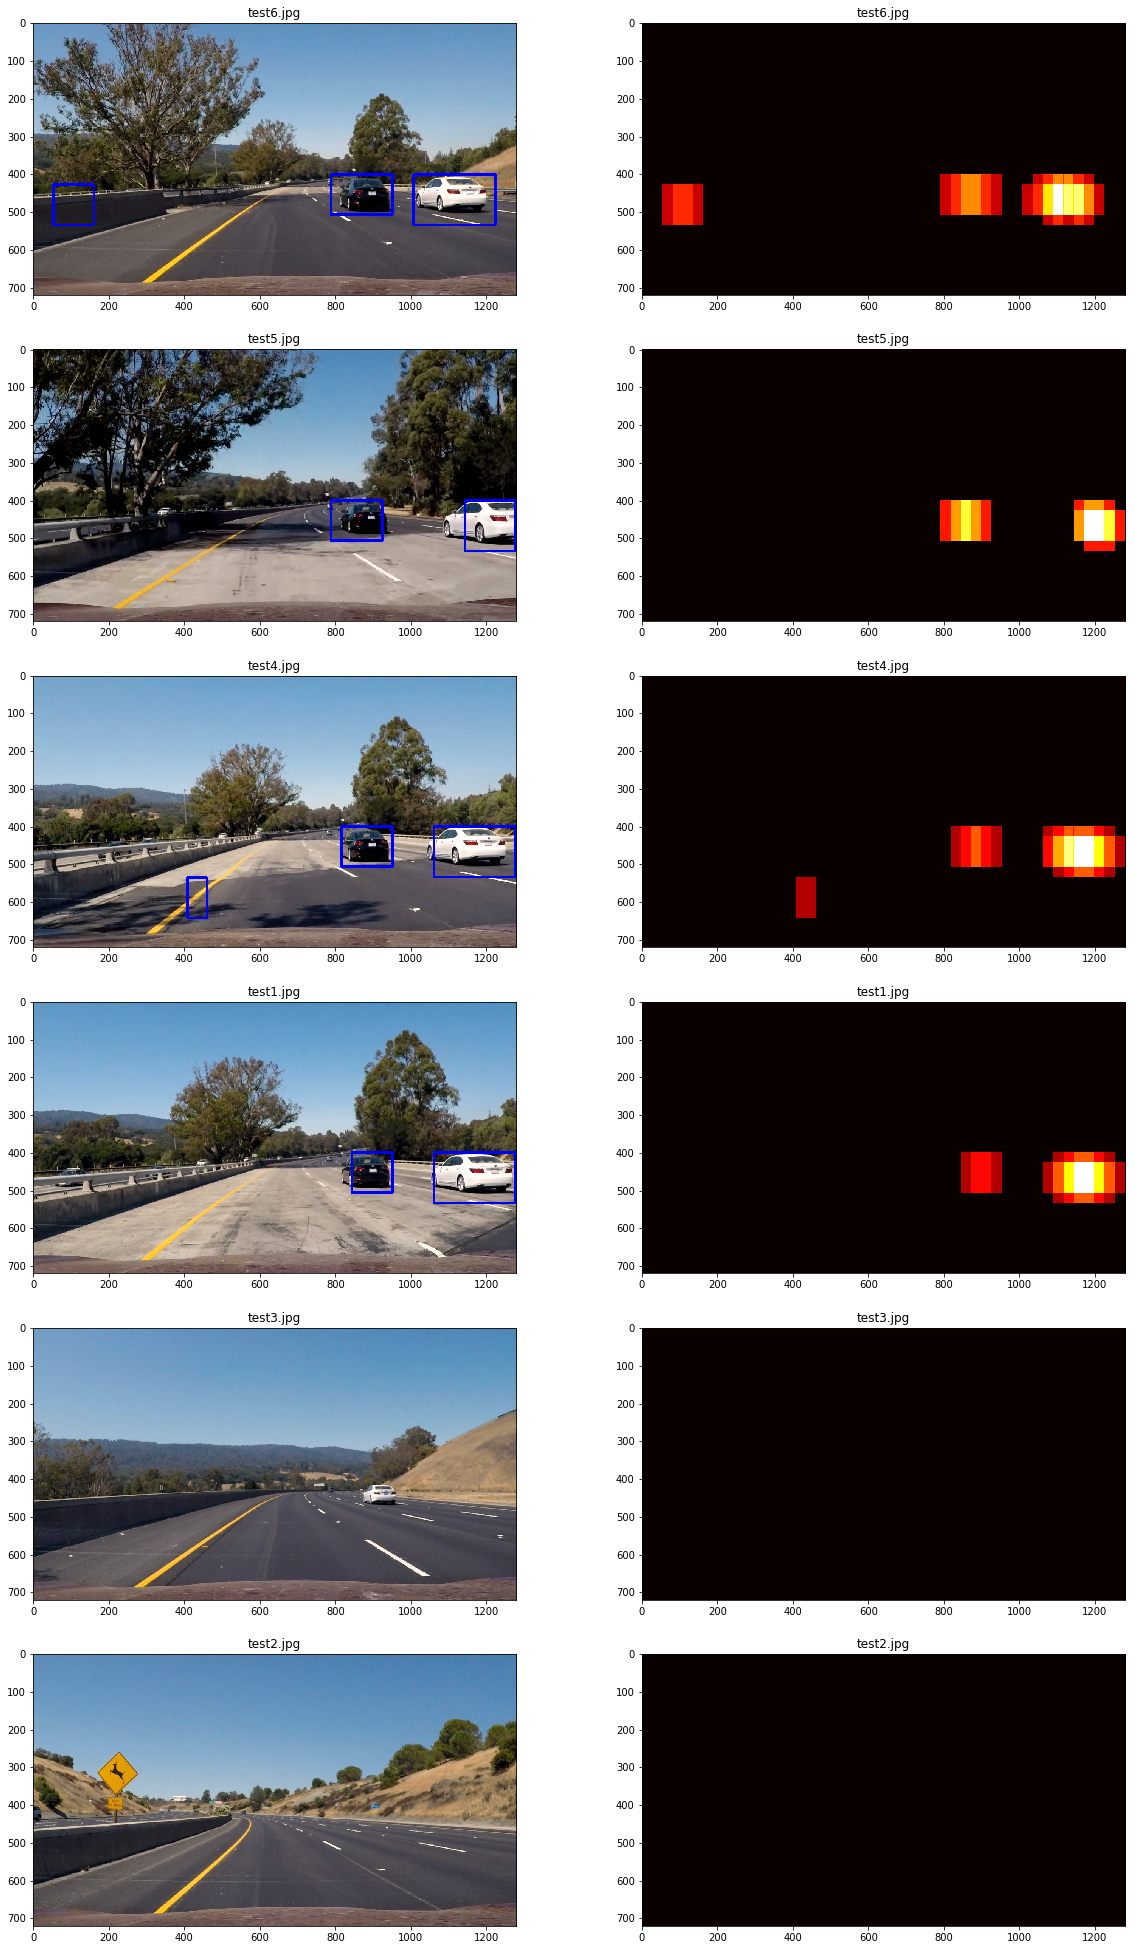

In [26]:
fig = plt.figure(figsize=(20,35))
visualize(6, 2, out_images, out_titles)

## Pipeline on each image

In [27]:
threshold = 1.9

def process_image(img):
    heatmap = np.zeros_like(img[:,:,0])
    out_img, img_boxes = find_cars(image=img, y_start=y_start, y_stop=y_stop, scale=scale, \
                            classifier=clf, X_scaler=scaler, orient=orient, pix_per_cell=pix_per_cell,\
                            cell_per_block=cell_per_block, spatial_size=spatial_size, hist_bins=hist_bins)    
    
    heatmap = add_heat(heatmap, img_boxes)    
    # remove false positives
    heatmap = apply_threshold(heatmap=heatmap, threshold=threshold)    
    # draw bounding boxes on a copy of the image
    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(np.copy(img), labels)
    
    return draw_img

print('done')

done


## Apply pipeline on video

In [28]:
# import everything to edit/save/watch video clips

from moviepy.editor import VideoFileClip
from IPython.display import HTML

output = 'test.mp4'
input_clip = VideoFileClip('test_video.mp4')

# output = 'project_video_output.mp4'
# input_clip = VideoFileClip('project_video.mp4')

output_clip = input_clip.fl_image(process_image)
# %time
output_clip.write_videofile(output, audio=False)

[MoviePy] >>>> Building video test.mp4
[MoviePy] Writing video test.mp4


 97%|█████████▋| 38/39 [00:22<00:00,  1.77it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test.mp4 



In [29]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output))

In [ ]:
# Define a class to receive the characteristics of each vehicle detection
# Objects defined as Vehicles will be where multiple overlapping detections exist in the heatmap
class Vehicle():
    def __init__(self):
        self.detected = False           # vehicle detected in the last iteration?
        self.n_detections = 0           # no of consective times this vehicle has been
        self.n_nondetections = 0
        self.xpixels = None             # pixel x-values of last detection
        self.ypixels = None
        self.recent_xfitted = []        # x position of the last n fits of the bounding box
        self.bestx = None               # avg. x position of the last n fits
        self.recent_yfitted = []
        self.besty = None
        self.recent_wfitted = []
        self.bestw = None
        self.recent_hfitted = []
        self.besth = None

In [ ]:
carlist = []
carlistst.append(Vehicle())